In [704]:
import numpy as np
import pickle
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import community
import difflib

In [750]:
# load in data
with open('/Users/rohanramesh/Documents/SportsData/NBA/AllYearlyData_2008_2018.pickle', 'rb') as handle:
    df_all_stats = pickle.load(handle)

with open('/Users/rohanramesh/Documents/SportsData/NBA/YearlyTeamData.pickle', 'rb') as handle:
    df_teams = pickle.load(handle)
    
years_to_use = range(2008,2019)

In [751]:
# have to redefined team names in df to match the players version
for curr_year in years_to_use[1:]:
    # need to adjust for difference betwen Tm labels
    # these are all teams according to the player data
    list_of_teams_mult = df_all_stats[str(curr_year)]['Tm']
    all_teams = list_of_teams_mult.drop_duplicates().tolist()

    # teams according to team df
    teams_according_to_team_df = df_teams[str(curr_year)]['Tm'].tolist()
    # remove everything after city name but before team acronym
    new_team_ = [curr_team[curr_team.rfind(" ")+1:] for curr_team in teams_according_to_team_df]
    # bc of team transferring from New Jersey to Brooklyn and websited not being up to date add
    if curr_year == 2012:
        new_team_ = [w.replace('BKN', 'NJN') for w in new_team_]
    
    # now iterate through new team and find best match from all_teams
    new_team_aligned = []
    for curr_team in new_team_:    
        new_team_aligned.append(difflib.get_close_matches(curr_team,all_teams, n=1)[0])

    df_teams[str(curr_year)]['Tm'] = new_team_aligned


In [803]:
# functions to build the Graphs
def build_graphs_each_team(df_all_stats,curr_year,curr_team):
    """ for any team on any particular year build a graph where all of the nodes are individual players 
    and the edges connecting players is a ratio between player A's relative assist rate and player B's
    relative scoring total. Each edge basically describes that pairs contribution to the teams scoring 
    at the level of assists and scoring
    ratio for edges = (100 * AST person A / AST total) * (100 * PS/G person B / PS/G total)"""
    idx = (df_all_stats[curr_year]['Tm'] == curr_team) & (df_all_stats[curr_year]['MP_adv'] > 200)
    Team_df = df_all_stats[curr_year][['Player','AST','PS/G','Pos','MP']][idx]
    # can't keep everyone bc some rosters bigger than others so will mess up stats - taking the top 8 players 
    Team_df = Team_df.sort_values(['MP'], ascending=False)
    Team_df = Team_df.iloc[0:8]
    curr_team_ast_pts = Team_df[['AST', 'PS/G']].values
    summed_ast_pts = curr_team_ast_pts.sum(axis=0)
    # lets make a matrix of all pairwise comparisons
    all_pairwise_edges = np.ndarray(shape= (np.shape(curr_team_ast_pts)[0],np.shape(curr_team_ast_pts)[0]))
    # build the ratio for edges = (100 * AST for a person / AST total) * (100 * PTS for a person / PTS total)
    for i in range(0,np.shape(curr_team_ast_pts)[0]):
        for j in range(0,np.shape(curr_team_ast_pts)[0]):
            all_pairwise_edges[i,j] = (100 * curr_team_ast_pts[i][0]/summed_ast_pts[0]) * (100 * curr_team_ast_pts[j][1]/summed_ast_pts[1])
#             all_pairwise_edges[i,j] = (curr_team_ast_pts[i][0]) * (curr_team_ast_pts[j][1])


    # for the nodes lets use player names
    pnames = Team_df['Player'].tolist()
    curr_positions = Team_df['Pos'].tolist()
    minutes_played = Team_df['MP'].tolist()
    unique_pos = list(set(curr_positions))
    cm = plt.get_cmap('inferno',5) # 5 bc of the 5 positions
    nodecolors = [cm.colors[j] for i in curr_positions for j in range(0,len(unique_pos)) if i == unique_pos[j]]
    node_size_use = Team_df['PS/G']
    node_size_use = node_size_use.as_matrix()
    G = nx.DiGraph()
    G.add_nodes_from(pnames)
    # to save the PS/G for node size later
    points_per_game = {}
    pos_ = {}
    mp_ = {}
    for i in range(0,len(pnames)):
        points_per_game[pnames[i]] = node_size_use[i]
        pos_[pnames[i]] = curr_positions[i]
        mp_[pnames[i]] = minutes_played[i]
    nx.set_node_attributes(G, points_per_game, 'ppg')
    nx.set_node_attributes(G, pos_, 'pos')
    nx.set_node_attributes(G, mp_, 'mp')
    labels_use = {}
    outward_vs_inward_direction = []
    for i in range(0,np.shape(curr_team_ast_pts)[0]):
        labels_use[pnames[i]] = pnames[i]
#         for j in range(0,np.shape(curr_team_ast_pts)[0]):
#                 G.add_edge(pnames[i],pnames[j], weight= all_pairwise_edges[i,j])
#                 G.add_edge(pnames[j],pnames[i], weight= all_pairwise_edges[j,i])
        for j in range(i+1,np.shape(curr_team_ast_pts)[0]):
            if (all_pairwise_edges[i,j] > all_pairwise_edges[j,i]):
                G.add_edge(pnames[i],pnames[j], weight= all_pairwise_edges[i,j])
                outward_vs_inward_direction.append('k')
            elif (all_pairwise_edges[j,i] > all_pairwise_edges[i,j]):
                G.add_edge(pnames[j],pnames[i], weight= all_pairwise_edges[j,i])
                outward_vs_inward_direction.append('k')
    return G

def visualize_graph_for_team_year(G):
    """ visualize the graph """
    pos = nx.kamada_kawai_layout(G)
#     pos=nx.spring_layout(G, iterations=500)
    # pos=nx.circular_layout(G)
    cm = plt.get_cmap('inferno_r',7) # 6 bc of the 5 positions and no black
    unique_pos = ['PG','SG','SF','PF','C']
    curr_positions = nx.get_node_attributes(G,'pos')
    nodecolors = [cm.colors[j] for i in curr_positions for j in range(0,len(unique_pos)) 
                  if curr_positions[i] == unique_pos[j]]
    edge_labels=dict([((u,v,),round(d['weight']))
                     for u,v,d in G.edges(data=True)])
    # for the node size
    node_size_use = nx.get_node_attributes(G,'ppg')
    node_array = [node_size_use[i]*25 for i in list(node_size_use)]
    labels_use = {}
    for i in G.nodes():
        labels_use[i] = i
    # print(edge_labels)
    edgewidth = [d['weight']/50 for (u, v, d) in G.edges(data=True)]
    # # we can now added edge thickness and edge color
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_array, node_color=nodecolors,alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.15, arrowstyle= 'simple', arrowsize=5, arrows=False,
                           edge_cmap=plt.cm.Greys)
    nx.draw_networkx_labels(G, pos, labels_use, font_size=8)
    plt.axis('off')
    plt.show()

def get_weighted_clustering(G, extra_weighting_values="None"):
    A = nx.algorithms.cluster.clustering(G, weight='weight')
    if extra_weighting_values != "None":
        from_node = nx.get_node_attributes(G,extra_weighting_values)
        weighted_val = [from_node[i] for i in list(from_node)]
        weighted_val = weighted_val/np.sum(weighted_val)
    all_cc = []
    for j, i in enumerate(A.keys()):
        if extra_weighting_values != "None":
            all_cc.append(A[i] * weighted_val[j])
        else:
            all_cc.append(A[i])
    return all_cc

def get_eigenvector_centrality(G, extra_weighting_values="None"):
    A = nx.eigenvector_centrality(G, weight='weight')
    if extra_weighting_values != "None":
        from_node = nx.get_node_attributes(G,extra_weighting_values)
        weighted_val = [from_node[i] for i in list(from_node)]
        weighted_val = weighted_val/np.sum(weighted_val)
    all_ec = []
    for j, i in enumerate(A.keys()):
        if extra_weighting_values != "None":
            all_ec.append(A[i] * weighted_val[j])
        else:
            all_ec.append(A[i])
    return all_ec

def plot_team_scatter(df,xstat,ystat,title='None'):
    fig, ax = plt.subplots()

    ax.scatter(df[xstat],df[ystat])

    for i, txt in enumerate(df['Tm']):
        ax.annotate(txt, (df[xstat][i],df[ystat][i]))
    if title != "None":
        plt.title(title)
    plt.xlabel(xstat)
    plt.ylabel(ystat)
    plt.show()


In [754]:
# iterate through all years and all teams and build all relevant graphs
all_team_graphs = {}
for curr_year in years_to_use[1:]:
    list_of_teams_mult = df_all_stats[str(curr_year)]['Tm']
    all_teams = list_of_teams_mult.drop_duplicates().tolist()
    all_team_graphs[str(curr_year)] = {}
    for curr_team in all_teams:
        all_team_graphs[str(curr_year)][curr_team] = build_graphs_each_team(
            df_all_stats,str(curr_year),curr_team)
        
    

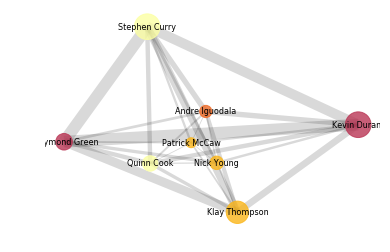

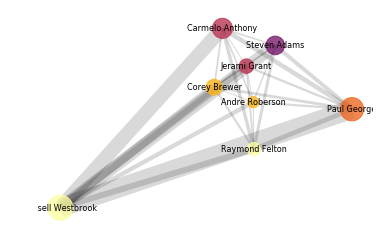

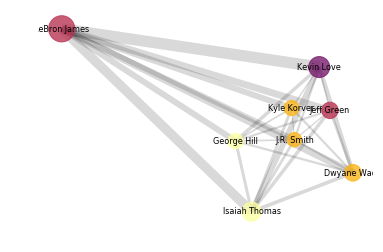

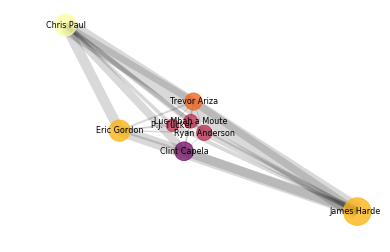

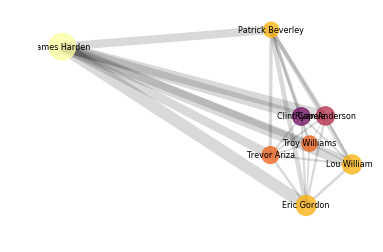

In [807]:
visualize_graph_for_team_year(all_team_graphs['2018']['GSW'])
visualize_graph_for_team_year(all_team_graphs['2018']['OKC'])
visualize_graph_for_team_year(all_team_graphs['2018']['CLE'])
visualize_graph_for_team_year(all_team_graphs['2018']['HOU'])
visualize_graph_for_team_year(all_team_graphs['2017']['HOU'])

In [783]:
# weighted clustering - weighted tendency of nodes to connect to other nodes
weight_clust = {}
weighted_clustering_idx = {}
for curr_year in years_to_use[1:]:
    weight_clust[str(curr_year)] = {}
    all_teams = df_teams[str(curr_year)]['Tm'].drop_duplicates().tolist()
    weighted_clustering_idx[str(curr_year)] = []
    for curr_team in all_teams:
        G = all_team_graphs[str(curr_year)][curr_team].to_undirected()
        A = get_weighted_clustering(G, extra_weighting_values="None")
        weight_clust[str(curr_year)][curr_team] = A
        # build a ratio of the top weighted value over the sum of the rest
        weighted_clustering_idx[str(curr_year)].append(np.mean(A))
    df_teams[str(curr_year)]['wclust_idx'] = weighted_clustering_idx[str(curr_year)]  

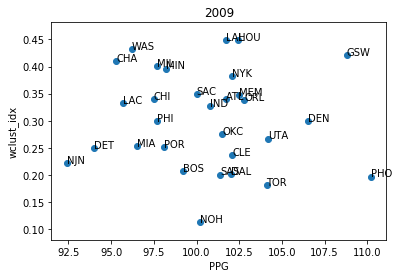

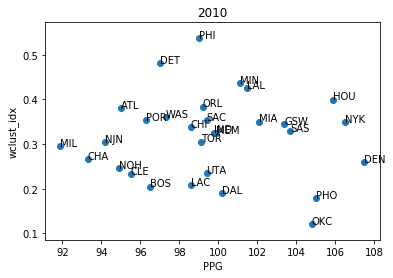

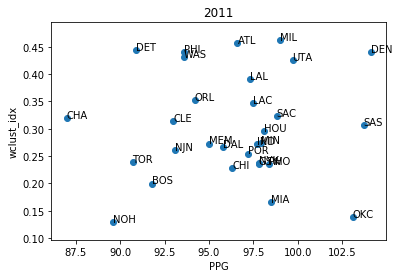

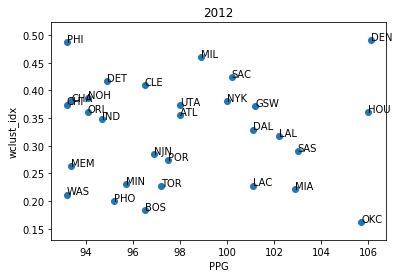

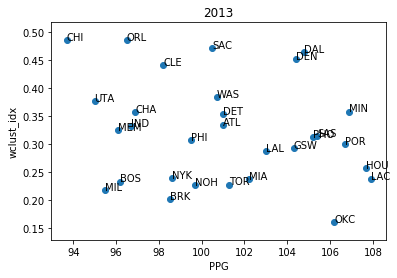

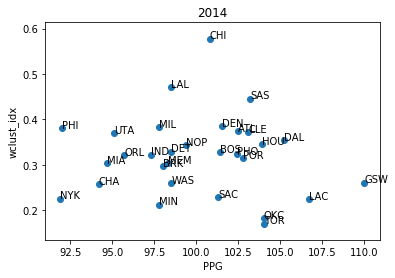

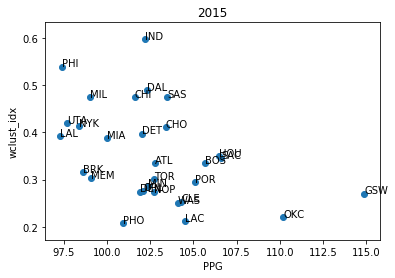

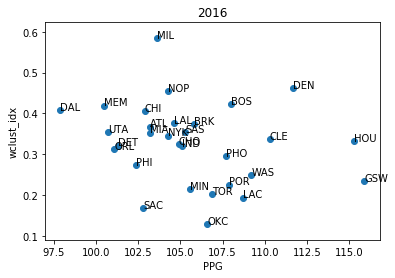

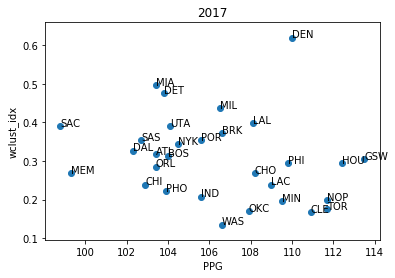

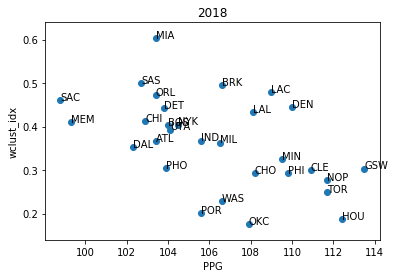

In [802]:
for curr_year in years_to_use[1:]:
    plot_team_scatter(df_teams[str(curr_year)],'PPG','wclust_idx',str(curr_year))


In [664]:
# shortest path length
G = all_team_graphs['2018']['GSW'].to_undirected()
A = dict(nx.shortest_path_length(G, weight='weight'))
print(A['Draymond Green'])

{'Draymond Green': 0, 'Patrick McCaw': 90.41591320072334, 'Nick Young': 122.06148282097651, 'Andre Iguodala': 131.28886026406403, 'Quinn Cook': 131.59850380242267, 'Klay Thompson': 177.11610394114297, 'Kevin Durant': 204.86016497807728, 'Stephen Curry': 204.86016497807728}


In [808]:
# eigenvector centrality - importance of single node
# G = all_team_graphs['2018']['HOU'].to_undirected()
# A = nx.eigenvector_centrality(G, weight='weight')
# all_cc = []
# for i in A.keys():
#     all_cc.append(A[i])
# print(A)
# print(np.max(all_cc))
eigcent = {}
eigcent_idx = {}
for curr_year in years_to_use[1:]:
    eigcent[str(curr_year)] = {}
    all_teams = df_teams[str(curr_year)]['Tm'].drop_duplicates().tolist()
    eigcent_idx[str(curr_year)] = []
    for curr_team in all_teams:
        G = all_team_graphs[str(curr_year)][curr_team].to_undirected()
        A = get_eigenvector_centrality(G, extra_weighting_values="None")
        eigcent[str(curr_year)][curr_team] = A
        # build a ratio of the top weighted value over the sum of the rest
        A.sort(reverse=True)
        eigcent_idx[str(curr_year)].append(A[0])
#         eigcent_idx[str(curr_year)].append(np.max(A)/np.mean(A))
    df_teams[str(curr_year)]['eigcent'] = eigcent_idx[str(curr_year)]  

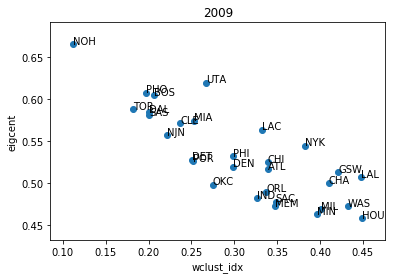

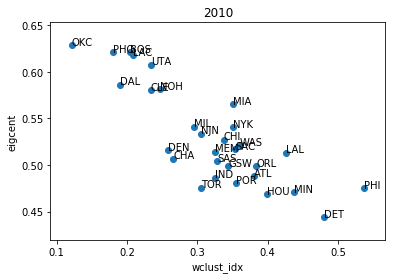

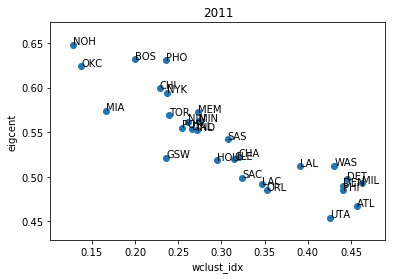

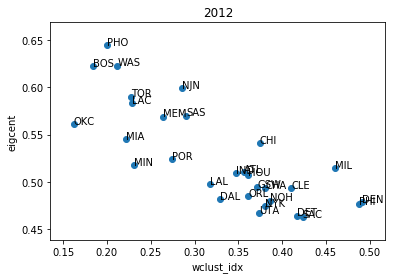

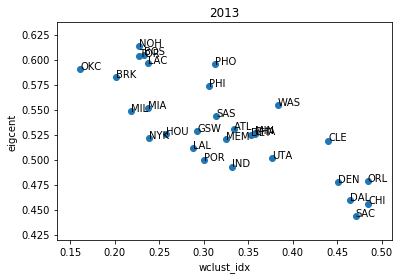

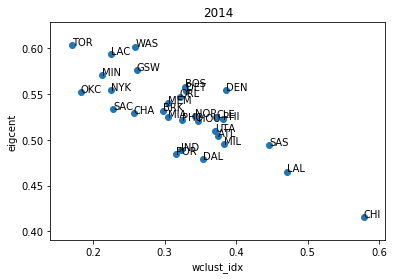

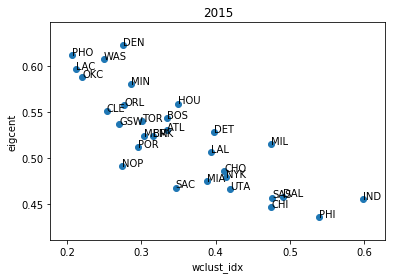

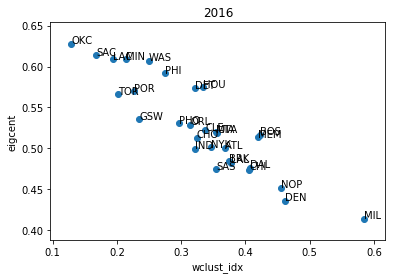

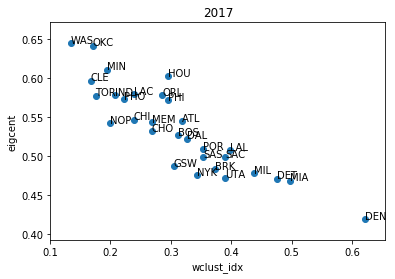

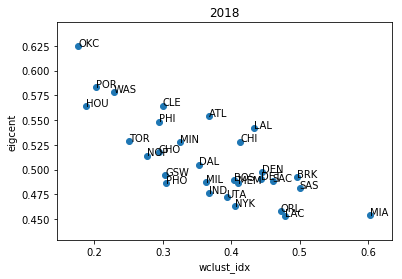

In [810]:
for curr_year in years_to_use[1:]:
    plot_team_scatter(df_teams[str(curr_year)],'wclust_idx','eigcent',str(curr_year))

In [666]:
# Pagerank - lower values are people who assist and higher are people who score
G = all_team_graphs['2018']['GSW']
pr = nx.pagerank_numpy(G)
print(pr)

{'Klay Thompson': 0.22045609058368432, 'Kevin Durant': 0.15082618938430803, 'Draymond Green': 0.050625116792372894, 'Stephen Curry': 0.10637465681556783, 'Andre Iguodala': 0.05321736674860886, 'Quinn Cook': 0.06421308754735051, 'Nick Young': 0.3000010992223331, 'Patrick McCaw': 0.054286392905774514}


In [669]:
# looking at average degree connectivity
G = all_team_graphs['2018']['OKC']
pr = nx.average_degree_connectivity(G,weight='weight')
print(pr)

{7: 3.499999999999999}


In [524]:
G = all_team_graphs['2018']['ATL']
for p1, p2, w in G.edges(data=True):
    print(p1,p2,w)

Luke Babbitt Kent Bazemore {'weight': 21.349999999999998}
Luke Babbitt DeAndre' Bembry {'weight': 11.589999999999998}
Luke Babbitt Tyler Cavanaugh {'weight': 4.27}
Luke Babbitt John Collins {'weight': 7.93}
Luke Babbitt Dewayne Dedmon {'weight': 9.149999999999999}
Luke Babbitt Malcolm Delaney {'weight': 18.299999999999997}
Luke Babbitt Tyler Dorsey {'weight': 8.54}
Luke Babbitt Ersan Ilyasova {'weight': 7.63}
Luke Babbitt Damion Lee {'weight': 11.589999999999998}
Luke Babbitt Josh Magette {'weight': 19.52}
Luke Babbitt Mike Muscala {'weight': 6.1}
Luke Babbitt Miles Plumlee {'weight': 4.88}
Luke Babbitt Dennis Schroder {'weight': 37.82}
Luke Babbitt Isaiah Taylor {'weight': 18.91}
Luke Babbitt Taurean Waller-Prince {'weight': 15.86}
Luke Babbitt Andrew White {'weight': 3.2199999999999998}
Kent Bazemore DeAndre' Bembry {'weight': 24.509999999999998}
Kent Bazemore Tyler Cavanaugh {'weight': 16.45}
Kent Bazemore John Collins {'weight': 36.75}
Kent Bazemore Dewayne Dedmon {'weight': 35.0}


In [655]:
print(Team_df.iloc[0:8])

                Player  AST  PS/G Pos    MP
0         Alex Abrines  0.4   4.7  SG  15.1
2         Steven Adams  1.2  13.9   C  32.7
16     Carmelo Anthony  1.3  16.2  PF  32.1
77        Corey Brewer  1.3  10.1  SG  28.6
192     Raymond Felton  2.5   6.9  PG  16.6
193  Terrance Ferguson  0.3   3.1  SG  12.5
209        Paul George  3.3  21.9  SF  36.6
219       Jerami Grant  0.7   8.4  PF  20.3


In [680]:
G = all_team_graphs['2018']['OKC'].to_undirected()
A = nx.algorithms.cluster.clustering(G, weight='weight')
minutes = nx.get_node_attributes(G,'mp')
weighted_minutes = [minutes[i] for i in list(minutes)]
weighted_minutes = weighted_minutes/np.sum(weighted_minutes)
all_cc = []
for j, i in enumerate(A.keys()):
    all_cc.append(A[i] * weighted_minutes[j])


Paul George
0.21817555380582088
0.15919965202261852
Russell Westbrook
0.29856958378987636
0.158329708568943
Steven Adams
0.16314749860206593
0.14223575467594604
Carmelo Anthony
0.1759397768827532
0.13962592431491952
Corey Brewer
0.1458054263537107
0.12440191387559807
Andre Roberson
0.11942852613868446
0.11570247933884296
Jerami Grant
0.12414459808628367
0.08829926054806436
Raymond Felton
0.16624308159359494
0.07220530665506741
0.023087403570073314


In [699]:
print(all_teams)

['OKC', 'BRK', 'MIA', 'ORL', 'MIN', 'SAS', 'BOS', 'NOP', 'POR', 'PHI', 'HOU', 'IND', 'MIL', 'TOR', 'CHI', 'DEN', 'ATL', 'CHO', 'NYK', 'LAL', 'DAL', 'WAS', 'GSW', 'PHO', 'LAC', 'SAC', 'DET', 'UTA', 'MEM', 'CLE', 'TOT']
